## Imports

In [2]:
# !pip install scipy==1.6.0
# !pip install matplotlib==3.1.0

In [2]:
import os, json, random
random.seed(1)
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import Markdown, display, Image
from tqdm import tqdm
from collections import OrderedDict
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# AIF360
import aif360
from aif360.datasets import CompasDataset
from aif360.sklearn.datasets import fetch_compas
# fairness metrics
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric, DatasetMetric
from aif360.metrics.common_utils import compute_metrics
from aif360.metrics.utils import compute_num_instances
# data preprocessing
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_compas
# explainers
from aif360.explainers import MetricTextExplainer
# bias mitigation techniques
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.inprocessing import AdversarialDebiasing, PrejudiceRemover, GerryFairClassifier
from aif360.sklearn.inprocessing import AdversarialDebiasing as SKLearnAdversarialDebiasing
from aif360.algorithms.inprocessing.gerryfair.clean import array_to_tuple
from aif360.algorithms.inprocessing.gerryfair.auditor import Auditor
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing, RejectOptionClassification
from aif360.sklearn.utils import check_inputs, check_groups

In [4]:
# TensorFlow
import tensorflow
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()

In [5]:
import sklearn
# scalers
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
# classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm, tree, linear_model
# metrics
from sklearn.metrics import accuracy_score, roc_curve, classification_report, confusion_matrix
# kernels
from sklearn.kernel_ridge import KernelRidge

from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.datasets import make_blobs
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.inspection import permutation_importance

## Helper Functions

In [6]:
FILES = '/Users/megantennies/FYP/saved data'

In [7]:
def save_to_json(filename, data):
    with open(os.path.join(FILES, filename), 'w') as write:
        json.dump(data, write)

In [8]:
def json_to_data(filename):
    with open(os.path.join(FILES, filename)) as file:
        data = json.load(file)
    df = pd.DataFrame(columns = data['columns'], data = data['data'])
    return df

In [9]:
def df_to_json(filename, df):
    df.to_json(os.path.join(FILES, filename), orient = 'split', 
    compression = 'infer', index = True)

## Data Loading 

In [10]:
privileged_groups = [{'race': 1}]
unprivileged_groups = [{'race': 0}]
original_dataset = load_preproc_data_compas(['race'])

In [11]:
default_mappings = {'label_maps': [{1.0: 'Recid', 0.0: 'Non-Recid'}], 
    'protected_attribute_maps': [{1.0: 'Male', 0.0: 'Female'}, 
    {1.0: 'White', 0.0: 'Non-White'}]}
metrics = ['Statistical parity difference', 'Average odds difference', 
    'Equal opportunity difference']

In [12]:
original_train, original_val_test = original_dataset.split([0.7], shuffle = True)
original_val, original_test = original_val_test.split([0.5], shuffle = True)

In [11]:
def describe(train = None, val = None, test = None):
    if train is not None:
        display(Markdown('#### Training dataset shape'))
        print(train.features.shape)
    if val is not None:
        display(Markdown('#### Validation dataset shape'))
        print(val.features.shape)
    display(Markdown('#### Test dataset shape'))
    print(test.features.shape)
    display(Markdown('#### Favorable and unfavorable labels'))
    print(test.favorable_label, test.unfavorable_label)
    display(Markdown('#### Protected attribute names'))
    print(test.protected_attribute_names)
    display(Markdown('#### Privileged and unprivileged protected attribute values'))
    print(test.privileged_protected_attributes, test.unprivileged_protected_attributes)
    display(Markdown("#### Dataset feature names"))
    print(train.feature_names)

In [12]:
describe(original_train, original_val, original_test)

#### Training dataset shape

(3694, 10)


#### Validation dataset shape

(792, 10)


#### Test dataset shape

(792, 10)


#### Favorable and unfavorable labels

0.0 1.0


#### Protected attribute names

['race']


#### Privileged and unprivileged protected attribute values

[array([1.])] [array([0.])]


#### Dataset feature names

['sex', 'race', 'age_cat=25 to 45', 'age_cat=Greater than 45', 'age_cat=Less than 25', 'priors_count=0', 'priors_count=1 to 3', 'priors_count=More than 3', 'c_charge_degree=F', 'c_charge_degree=M']


In [13]:
original_metric = BinaryLabelDatasetMetric(original_train, 
    unprivileged_groups = unprivileged_groups, 
    privileged_groups = privileged_groups)

In [14]:
original_explainer = MetricTextExplainer(original_metric)
display(Markdown('#### Original COMPAS training data'))

original_train_metric = BinaryLabelDatasetMetric(original_train, 
    unprivileged_groups = unprivileged_groups, privileged_groups = privileged_groups)
print('Training data: Difference in mean outcomes between unprivileged and privileged groups = %f' % original_train_metric.mean_difference())

original_val_metric = BinaryLabelDatasetMetric(original_val, 
    unprivileged_groups = unprivileged_groups, privileged_groups = privileged_groups)
print('Validation data: Difference in mean outcomes between unprivileged and privileged groups = %f' % original_val_metric.mean_difference())

original_test_metric = BinaryLabelDatasetMetric(original_test, 
    unprivileged_groups = unprivileged_groups, privileged_groups = privileged_groups)
print('Testing data: Difference in mean outcomes between unprivileged and privileged groups = %f' % original_test_metric.mean_difference())

#### Original COMPAS training data

Training data: Difference in mean outcomes between unprivileged and privileged groups = -0.140541
Validation data: Difference in mean outcomes between unprivileged and privileged groups = -0.077290
Testing data: Difference in mean outcomes between unprivileged and privileged groups = -0.148322


## Baseline Logistic Regression Model

In [77]:
original_scaler = StandardScaler()
X_train = original_scaler.fit_transform(original_train.features)
y_train = original_train.labels.ravel()
w_train = original_train.instance_weights.ravel()

In [78]:
lr = LogisticRegression()
lr.fit(X_train, y_train, sample_weight = original_train.instance_weights)
y_train_preds = lr.predict(X_train)

In [79]:
pos_ind = np.where(lr.classes_ == original_train.favorable_label)[0][0]

In [80]:
original_train_preds = original_train.copy()
original_train_preds.labels = y_train_preds

original_val_preds = original_val.copy(deepcopy = True)
X_val = original_scaler.transform(original_val_preds.features)
y_val = original_val_preds.labels
original_val_preds.scores = lr.predict_proba(X_val)[:, pos_ind].reshape(-1, 1)

original_test_preds = original_test.copy(deepcopy = True)
X_test = original_scaler.transform(original_test_preds.features)
y_test = original_test_preds.labels
original_test_preds.scores = lr.predict_proba(X_test)[:, pos_ind].reshape(-1, 1)

In [81]:
num_thresh = 100
bal_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)

for idx, class_thresh in enumerate(class_thresh_arr):
    fav_inds = original_val_preds.scores > class_thresh
    original_val_preds.labels[fav_inds] = original_val_preds.favorable_label
    original_val_preds.labels[~fav_inds] = original_val_preds.unfavorable_label

    original_val_metric = ClassificationMetric(original_val, 
        original_val_preds, unprivileged_groups = unprivileged_groups, 
        privileged_groups = privileged_groups)

    bal_arr[idx] = 0.5 * (original_val_metric.true_positive_rate() 
        + original_val_metric.true_negative_rate())

In [82]:
best_ind = np.where(bal_arr == np.max(bal_arr))[0][0]
best_class_thresh = class_thresh_arr[best_ind]

display(Markdown('#### Original COMPAS data'))
print('Best balanced accuracy (no transforming): %.4f' % np.max(bal_arr))
print('Optimal classification threshold (no transforming): %.4f' % best_class_thresh)

#### Original COMPAS data

Best balanced accuracy (no transforming): 0.6582
Optimal classification threshold (no transforming): 0.5445


In [83]:
bal_acc_arr = []
disp_imp_arr = []
avg_odds_diff_arr = []
eq_opp_diff_arr = []
outcome_unfair_arr = []
acc_equal_arr = []

In [84]:
display(Markdown('#### Predictions from the original testing data'))
print('Classification threshold used: %.4f' % best_class_thresh)

for thresh in tqdm(class_thresh_arr):
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    fav_inds = original_test_preds.scores > thresh
    original_test_preds.labels[fav_inds] = original_test_preds.favorable_label
    original_test_preds.labels[~fav_inds] = original_test_preds.unfavorable_label
    
    metric_test = compute_metrics(original_test, original_test_preds, \
        unprivileged_groups, privileged_groups, disp = disp)
    class_metric_test = ClassificationMetric(original_test, original_test_preds, \
        unprivileged_groups, privileged_groups)
    
    bal_acc_arr.append(metric_test['Balanced accuracy'])
    avg_odds_diff_arr.append(metric_test['Average odds difference'])
    disp_imp_arr.append(metric_test['Disparate impact'])
    eq_opp_diff_arr.append(metric_test['Equal opportunity difference'])
    outcome_unfair_arr.append(class_metric_test.false_discovery_rate_difference() \
        + class_metric_test.false_positive_rate_difference())
    acc_equal_arr.append((class_metric_test.true_positive_rate(privileged = True) + \
        class_metric_test.true_negative_rate(privileged = True)) - \
            (class_metric_test.true_positive_rate(privileged = False) + \
                class_metric_test.true_negative_rate(privileged = False)))

#### Predictions from the original testing data

 71%|███████   | 71/100 [00:00<00:00, 328.13it/s]

Classification threshold used: 0.5445
Balanced accuracy = 0.6764
Statistical parity difference = -0.3400
Disparate impact = 0.4908
Average odds difference = -0.3021
Equal opportunity difference = -0.3199
Theil index = 0.2498


invalid value encountered in double_scalars
100%|██████████| 100/100 [00:00<00:00, 365.88it/s]


In [85]:
save_to_json(filename = 'LR_bal_acc_arr.json', data = bal_acc_arr)
save_to_json(filename = 'LR_disp_imp_arr.json', data = disp_imp_arr)
save_to_json(filename = 'LR_avg_odds_diff_arr.json', data = avg_odds_diff_arr)
save_to_json(filename = 'LR_eq_opp_diff_arr.json', data = eq_opp_diff_arr)
save_to_json(filename = 'LR_outcome_unfair_arr.json', data = outcome_unfair_arr)
save_to_json(filename = 'LR_acc_equal_arr.json', data = acc_equal_arr)

In [86]:
LR_bal_acc = np.interp(best_class_thresh, class_thresh_arr, bal_acc_arr)
LR_acc_equal = np.interp(best_class_thresh, class_thresh_arr, acc_equal_arr)
LR_disp_imp = np.interp(best_class_thresh, class_thresh_arr, disp_imp_arr)
LR_out_unf = np.interp(best_class_thresh, class_thresh_arr, outcome_unfair_arr)
LR_avg_odds = np.interp(best_class_thresh, class_thresh_arr, avg_odds_diff_arr)
LR_eq_odds = np.interp(best_class_thresh, class_thresh_arr, eq_opp_diff_arr)

In [87]:
LR_results = {'Metric': ['Balanced Accuracy', 'Accuracy Equality', 'Disparate Impact', 'Outcome Unfairess', 'Average Odds Difference', 'Equal Opportunity Difference'],
    'Logistic Regression': [LR_bal_acc, LR_acc_equal, LR_disp_imp, LR_out_unf, LR_avg_odds, LR_eq_odds]}
LR_results_df = pd.DataFrame(LR_results)
df_to_json(filename = 'LR_results.json', df = LR_results_df)
LR_results_df

,Metric,Logistic Regression
0,Balanced Accuracy,0.676400
1,Accuracy Equality,0.035523
2,Disparate Impact,0.490774
3,Outcome Unfairess,-0.276927
4,Average Odds Difference,-0.302140
5,Equal Opportunity Difference,-0.319902


## Applying Bias Mitigation Techniques

### Reweighing

**Reweighing the dataset**

In [88]:
original_train_rw = original_train.copy(deepcopy = True)

In [89]:
rw = Reweighing(unprivileged_groups = unprivileged_groups, 
    privileged_groups = privileged_groups)
rw.fit(original_train_rw)
reweighed_train = rw.transform(original_train_rw)

**Calculating the weights used for each class**

The weights are calculated as follows:
$$ W_{positive privileged} = \frac{N_{privileged}*N_{positive}}{N_{all}*N_{positive privileged}} $$

In [90]:
def get_weightings(processor, dataset):
    priv_cond, unpriv_cond, fav_cond, unfav_cond, \
    cond_p_fav, cond_p_unfav, cond_up_fav, cond_up_unfav = \
        processor._obtain_conditionings(dataset)
    
    n = np.sum(dataset.instance_weights, dtype = np.float64)
    n_p = np.sum(dataset.instance_weights[priv_cond], dtype = np.float64)
    n_up = np.sum(dataset.instance_weights[unpriv_cond], dtype = np.float64)
    n_fav = np.sum(dataset.instance_weights[fav_cond], dtype = np.float64)
    n_unfav = np.sum(dataset.instance_weights[unfav_cond], dtype = np.float64)

    n_p_fav = np.sum(dataset.instance_weights[cond_p_fav], dtype = np.float64)
    n_p_unfav = np.sum(dataset.instance_weights[cond_p_unfav],
        dtype = np.float64)
    n_up_fav = np.sum(dataset.instance_weights[cond_up_fav],
        dtype = np.float64)
    n_up_unfav = np.sum(dataset.instance_weights[cond_up_unfav],
        dtype = np.float64)
    
    w_p_fav = n_fav * n_p / (n * n_p_fav)
    w_p_unfav = n_unfav * n_p / (n * n_p_unfav)
    w_up_fav = n_fav * n_up / (n * n_up_fav)
    w_up_unfav = n_unfav * n_up / (n * n_up_unfav)

    weights = {'Race': ['White', 'White', 'Non-White', 'Non-White'],
        'Label': [0.0, 1.0, 0.0, 1.0],
        'Weight': [w_p_fav, w_p_unfav, w_up_fav, w_up_unfav]}
    return weights

In [91]:
updated_weights = get_weightings(processor = rw, dataset = original_train_rw)
updated_weights = pd.DataFrame(updated_weights)
display(Markdown('#### Weights for the Reweighed training data'))
updated_weights

#### Weights for the Reweighed training data

,Race,Label,Weight
0,White,0.0,0.863650
1,White,1.0,1.218949
2,Non-White,0.0,1.112318
3,Non-White,1.0,0.896954


**Calculating fairness metrics on the reweighed dataset**

In [92]:
assert np.abs(reweighed_train.instance_weights.sum() 
    - original_train_rw.instance_weights.sum()) < 1e-6

In [94]:
reweighed_metric = BinaryLabelDatasetMetric(reweighed_train, 
    unprivileged_groups = unprivileged_groups, privileged_groups = privileged_groups)
reweighed_explainer = MetricTextExplainer(reweighed_metric)
display(Markdown('#### Reweighed COMPAS training data'))
print(reweighed_explainer.disparate_impact())
reweighed_train_metric = BinaryLabelDatasetMetric(reweighed_train, 
    unprivileged_groups = unprivileged_groups, privileged_groups = privileged_groups)
print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % reweighed_train_metric.mean_difference())

#### Reweighed COMPAS training data

Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.9999999999999998
Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.000000


In [95]:
assert np.abs(reweighed_metric.mean_difference()) < 1e-6

**Training LR model on the reweighed data**

In [96]:
reweighed_scaler = StandardScaler()
X_train_rw = reweighed_scaler.fit_transform(reweighed_train.features)
y_train_rw = reweighed_train.labels.ravel()

In [97]:
lr = LogisticRegression()
lr.fit(X_train_rw, y_train_rw, sample_weight = reweighed_train.instance_weights)
y_train_preds_rw = lr.predict(X_train_rw)

In [98]:
reweighed_test_preds = original_test.copy(deepcopy = True)
X_test_rw = reweighed_scaler.fit_transform(reweighed_test_preds.features)
y_test_rw = reweighed_test_preds.labels
reweighed_test_preds.scores = lr.predict_proba(X_test_rw)[:, pos_ind].reshape(-1, 1)

**Calculating results over all classification thresholds**

In [99]:
RW_bal_acc_arr = []
RW_disp_imp_arr = []
RW_avg_odds_diff_arr = []
RW_eq_opp_diff_arr = []
RW_outcome_unfair_arr = []
RW_acc_equal_arr = []

display(Markdown('#### Predictions from the transformed testing data'))
print('Classification threshold used: %.4f' % best_class_thresh)

for thresh in tqdm(class_thresh_arr):
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    fav_inds = reweighed_test_preds.scores > thresh
    reweighed_test_preds.labels[fav_inds] = reweighed_test_preds.favorable_label
    reweighed_test_preds.labels[~fav_inds] = reweighed_test_preds.unfavorable_label
    
    rw_metric_test = compute_metrics(original_test, reweighed_test_preds, 
        unprivileged_groups, privileged_groups, disp = disp)
    rw_class_metric_test = ClassificationMetric(original_test, reweighed_test_preds, \
        unprivileged_groups, privileged_groups)
    
    RW_bal_acc_arr.append(rw_metric_test['Balanced accuracy'])
    RW_avg_odds_diff_arr.append(rw_metric_test['Average odds difference'])
    RW_disp_imp_arr.append(rw_metric_test['Disparate impact'])
    RW_eq_opp_diff_arr.append(rw_metric_test['Equal opportunity difference'])
    RW_outcome_unfair_arr.append(rw_class_metric_test.false_discovery_rate_difference() \
        + rw_class_metric_test.false_positive_rate_difference())
    RW_acc_equal_arr.append((rw_class_metric_test.true_positive_rate(privileged = True) + \
        rw_class_metric_test.true_negative_rate(privileged = True)) - \
            (rw_class_metric_test.true_positive_rate(privileged = False) + \
                rw_class_metric_test.true_negative_rate(privileged = False)))

#### Predictions from the transformed testing data

 69%|██████▉   | 69/100 [00:00<00:00, 320.30it/s]

Classification threshold used: 0.5445
Balanced accuracy = 0.6567
Statistical parity difference = 0.0005
Disparate impact = 1.0010
Average odds difference = 0.0370
Equal opportunity difference = 0.0357
Theil index = 0.2449


divide by zero encountered in double_scalars
invalid value encountered in double_scalars
100%|██████████| 100/100 [00:00<00:00, 352.91it/s]


In [100]:
save_to_json(filename = 'RW_bal_acc_arr.json', data = RW_bal_acc_arr)
save_to_json(filename = 'RW_disp_imp_arr.json', data = RW_disp_imp_arr)
save_to_json(filename = 'RW_avg_odds_diff_arr.json', data = RW_avg_odds_diff_arr)
save_to_json(filename = 'RW_eq_opp_diff_arr.json', data = RW_eq_opp_diff_arr)
save_to_json(filename = 'RW_outcome_unfair_arr.json', data = RW_outcome_unfair_arr)
save_to_json(filename = 'RW_acc_equal_arr.json', data = RW_acc_equal_arr)

**Calculating results at the best classification threshold**

In [101]:
RW_bal_acc = np.interp(best_class_thresh, class_thresh_arr, RW_bal_acc_arr)
RW_acc_equal = np.interp(best_class_thresh, class_thresh_arr, RW_acc_equal_arr)
RW_disp_imp = np.interp(best_class_thresh, class_thresh_arr, RW_disp_imp_arr)
RW_out_unf = np.interp(best_class_thresh, class_thresh_arr, RW_outcome_unfair_arr)
RW_avg_odds = np.interp(best_class_thresh, class_thresh_arr, RW_avg_odds_diff_arr)
RW_eq_odds = np.interp(best_class_thresh, class_thresh_arr, RW_eq_opp_diff_arr)

In [102]:
RW_results = {'Metric': ['Balanced Accuracy', 'Accuracy Equality', 'Disparate Impact', 'Outcome Unfairess', 'Average Odds Difference', 'Equal Opportunity Difference'],
    'Reweighing': [RW_bal_acc, RW_acc_equal, RW_disp_imp, RW_out_unf, RW_avg_odds, RW_eq_odds]}
RW_results_df = pd.DataFrame(RW_results)
df_to_json(filename = 'RW_results.json', df = RW_results_df)
RW_results_df

,Metric,Reweighing
0,Balanced Accuracy,0.656675
1,Accuracy Equality,0.002596
2,Disparate Impact,1.001024
3,Outcome Unfairess,0.151314
4,Average Odds Difference,0.037048
5,Equal Opportunity Difference,0.035749


### Prejudice Remover

In [43]:
original_train_pr = original_train.copy(deepcopy = True)

sens_ind = 0
sens_attr = original_train_pr.protected_attribute_names[sens_ind]

unprivileged_groups = [{sens_attr: v} for v in original_train_pr.unprivileged_protected_attributes[sens_ind]]
privileged_groups = [{sens_attr: v} for v in original_train_pr.privileged_protected_attributes[sens_ind]]

In [44]:
pr = PrejudiceRemover(sensitive_attr = sens_attr, eta = 10000)
pred_scaler = StandardScaler()
pred_train = original_train_pr.copy()
pred_train.features = pred_scaler.fit_transform(pred_train.features)
pr = pr.fit(pred_train)

In [45]:
pred_val = original_val.copy(deepcopy = True)
pred_val.features = pred_scaler.transform(pred_val.features)
y_train_preds_pr = pr.predict(pred_train).scores

In [46]:
PR_bal_acc_arr = []
PR_disp_imp_arr = []
PR_avg_odds_diff_arr = []
PR_eq_opp_diff_arr = []
PR_outcome_unfair_arr = []
PR_acc_equal_arr = []

In [47]:
save_to_json(filename = 'PR_bal_acc_arr.json', data = PR_bal_acc_arr)
save_to_json(filename = 'PR_disp_imp_arr.json', data = PR_disp_imp_arr)
save_to_json(filename = 'PR_avg_odds_diff_arr.json', data = PR_avg_odds_diff_arr)
save_to_json(filename = 'PR_eq_opp_diff_arr.json', data = PR_eq_opp_diff_arr)
save_to_json(filename = 'PR_outcome_unfair_arr.json', data = PR_outcome_unfair_arr)
save_to_json(filename = 'PR_acc_equal_arr.json', data = PR_acc_equal_arr)

In [48]:
for thresh in tqdm(class_thresh_arr):
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False

    y_val_preds = (y_train_preds_pr[:, pos_ind] > thresh).astype(np.float64)
    pred_test_preds = pred_train.copy()
    pred_test_preds.labels = y_val_preds
    
    pr_metric_test = compute_metrics(pred_train, pred_test_preds, 
        unprivileged_groups, privileged_groups, disp = disp)
    pr_class_metric_test = ClassificationMetric(pred_train, pred_test_preds, \
        unprivileged_groups, privileged_groups)
    
    PR_bal_acc_arr.append(pr_metric_test['Balanced accuracy'])
    PR_avg_odds_diff_arr.append(pr_metric_test['Average odds difference'])
    PR_disp_imp_arr.append(pr_metric_test['Disparate impact'])
    PR_eq_opp_diff_arr.append(pr_metric_test['Equal opportunity difference'])
    PR_outcome_unfair_arr.append(pr_class_metric_test.false_discovery_rate_difference() \
        + pr_class_metric_test.false_positive_rate_difference())
    PR_acc_equal_arr.append((pr_class_metric_test.true_positive_rate(privileged = True) + \
        pr_class_metric_test.true_negative_rate(privileged = True)) - \
            (pr_class_metric_test.true_positive_rate(privileged = False) + \
                pr_class_metric_test.true_negative_rate(privileged = False)))

 81%|████████  | 81/100 [00:00<00:00, 150.65it/s]

Balanced accuracy = 0.4438
Statistical parity difference = -0.0135
Disparate impact = 0.9781
Average odds difference = -0.0042
Equal opportunity difference = -0.2008
Theil index = 0.3295


100%|██████████| 100/100 [00:00<00:00, 160.07it/s]


In [49]:
PR_bal_acc = np.interp(best_class_thresh, class_thresh_arr, PR_bal_acc_arr)
PR_acc_equal = np.interp(best_class_thresh, class_thresh_arr, PR_acc_equal_arr)
PR_disp_imp = np.interp(best_class_thresh, class_thresh_arr, PR_disp_imp_arr)
PR_out_unf = np.interp(best_class_thresh, class_thresh_arr, PR_outcome_unfair_arr)
PR_avg_odds = np.interp(best_class_thresh, class_thresh_arr, PR_avg_odds_diff_arr)
PR_eq_odds = np.interp(best_class_thresh, class_thresh_arr, PR_eq_opp_diff_arr)

In [50]:
PR_results = {'Metric': ['Balanced Accuracy', 'Accuracy Equality', 'Disparate Impact', 'Outcome Unfairess', 'Average Odds Difference', 'Equal Opportunity Difference'],
    'Prejudice Remover': [PR_bal_acc, PR_acc_equal, PR_disp_imp, PR_out_unf, PR_avg_odds, PR_eq_odds]}
PR_results_df = pd.DataFrame(PR_results)
df_to_json(filename = 'PR_results.json', df = PR_results_df)
PR_results_df

,Metric,Prejudice Remover
0,Balanced Accuracy,0.443809
1,Accuracy Equality,0.393082
2,Disparate Impact,0.978114
3,Outcome Unfairess,0.488907
4,Average Odds Difference,-0.004250
5,Equal Opportunity Difference,-0.200791


### Adversarial Debiasing

In [103]:
# session.close()
# tf.reset_default_graph()
session = tf.Session()

In [104]:
X, y = fetch_compas(binary_race = True)
X.index = pd.MultiIndex.from_arrays(X.index.codes, names = X.index.names)
y.index = pd.MultiIndex.from_arrays(y.index.codes, names = y.index.names)
y = 1 - pd.Series(y.factorize(sort = True)[0], index = y.index)

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1234567)
data_preproc = make_column_transformer((OneHotEncoder(sparse = False, handle_unknown = 'ignore'), 
        X_train.dtypes == 'category'), remainder = StandardScaler())
X_train = pd.DataFrame(data_preproc.fit_transform(X_train), index = X_train.index)
X_test = pd.DataFrame(data_preproc.transform(X_test), index = X_test.index)

**Hyperparameter Training: finding optimal adversary loss weight**

In [106]:
def find_loss_weights(loss_weights):
    weights = {'Adversarial Loss Weight': [], 'Mean Accuracy': []}
    for weight in loss_weights:
        ad = SKLearnAdversarialDebiasing(prot_attr = 'race', adversary_loss_weight = weight)
        ad = ad.fit(X_train, y_train)
        acc_score = ad.score(X_train, y_train)
        weights['Adversarial Loss Weight'].append(weight)
        weights['Mean Accuracy'].append(acc_score)
    return pd.DataFrame(weights)

In [108]:
loss_weights = [i for i in np.linspace(0.01, 1.0, 100)]
weights = find_loss_weights(loss_weights = loss_weights)

In [98]:
def plot_params(param, metric, param_data, best_x, best_y, title, file_name):
    plt.figure(figsize = (12, 8))
    sns.set_style('whitegrid')
    ax = sns.lineplot(x = param, y = metric, data = param_data, color = '#6aac6c')
    if param == 'Adversarial Loss Weight':
        ax.annotate(s = ' x = {:.2f}, y = {:.2f}'.format(best_x, best_y), xy = (best_x, best_y))
    elif param == 'Number of Hidden Units':
        ax.annotate(s = ' x = {:}, \n y = {:.2f}'.format(best_x, best_y), xy = (best_x, best_y))
    plt.title(title)
    plt.savefig(file_name, bbox_inches = 'tight')

In [109]:
max = weights['Mean Accuracy'].max()
weight = weights.loc[weights['Mean Accuracy'] == max]
print(weight)

    Adversarial Loss Weight  Mean Accuracy
16                     0.17        0.78958


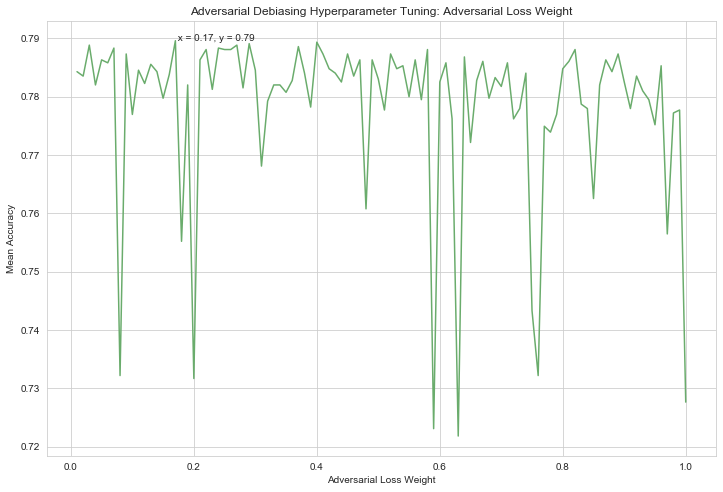

In [110]:
plot_params(param = 'Adversarial Loss Weight', metric = 'Mean Accuracy', 
    param_data = weights, best_x = 0.17, best_y = 0.78958,
    file_name = 'debiased_params_weights.png',
    title = 'Adversarial Debiasing Hyperparameter Tuning: Adversarial Loss Weight')

**Hyperparameter Training: finding optimal number of hidden units**

In [111]:
def find_hidden_units(num_hidden_units):
    units = {'Number of Hidden Units': [], 'Mean Accuracy': []}
    for unit in num_hidden_units:
        ad = SKLearnAdversarialDebiasing(prot_attr = 'race', classifier_num_hidden_units = unit)
        ad.fit(X_train, y_train)
        acc_score = ad.score(X_train, y_train)
        units['Number of Hidden Units'].append(unit)
        units['Mean Accuracy'].append(acc_score)
    return pd.DataFrame(units)

In [112]:
num_hidden_units = [int(i) for i in np.linspace(1, 500, 100)]
units = find_hidden_units(num_hidden_units = num_hidden_units)

In [113]:
max = units['Mean Accuracy'].max()
unit = units.loc[units['Mean Accuracy'] == max]
print(unit)

    Number of Hidden Units  Mean Accuracy
96                     484       0.810572


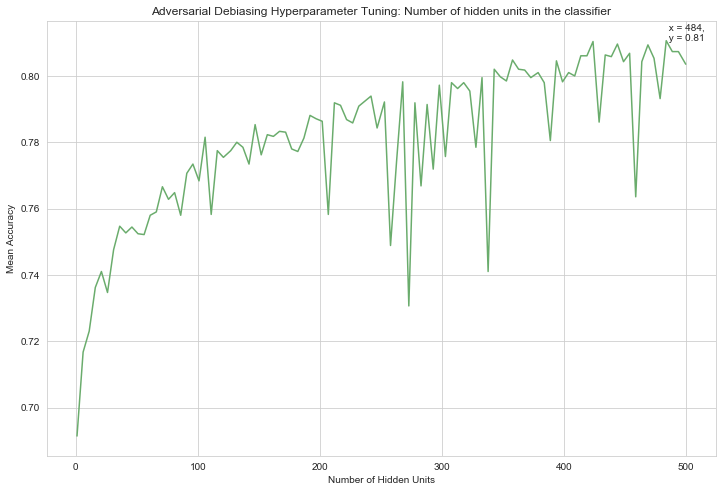

In [114]:
plot_params(param = 'Number of Hidden Units', param_data = units, metric = 'Mean Accuracy',
    title = 'Adversarial Debiasing Hyperparameter Tuning: Number of hidden units in the classifier', 
    file_name = 'debiased_params_units.png', best_x = 484, best_y = 0.810572)

**Training AD model with optimal hyperparameters**

In [109]:
session.close()
tf.reset_default_graph()
session = tf.Session()

In [110]:
ad = AdversarialDebiasing(privileged_groups = privileged_groups, 
    unprivileged_groups = unprivileged_groups, scope_name = 'debiased_classifier', 
    debias = True, sess = session, num_epochs = 100, batch_size = 8,
    classifier_num_hidden_units = 484, adversary_loss_weight = 0.17)
debiased_scaler = StandardScaler()
debiased_train = original_train.copy(deepcopy = True)
debiased_train.features = debiased_scaler.fit_transform(debiased_train.features)
ad = ad.fit(debiased_train)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
epoch 0; iter: 0; batch classifier loss: 0.722300; batch adversarial loss: 0.682827
epoch 0; iter: 200; batch classifier loss: 0.356867; batch adversarial loss: 0.707636
epoch 0; iter: 400; batch classifier loss: 0.785977; batch adversarial loss: 0.778352
epoch 1; iter: 0; batch classifier loss: 0.542411; batch adversarial loss: 0.734039
epoch 1; iter: 200; batch classifier loss: 0.671310; batch adversarial loss: 0.689579
epoch 1; iter: 400; batch classifier loss: 0.668131; batch adversarial loss: 0.641760
epoch 2; iter: 0; batch classifier loss: 0.746552; batch adversarial loss: 0.684859
epoch 2; iter: 200; batch classifier loss: 0.466131; batch adversarial loss: 0.711479
epoch 2; iter: 400; batch classifier loss: 0.888480; batch adversarial loss: 0.631398
epoch 3; iter: 0; batch classifier loss: 0.576691; batch adversarial loss: 0.706112
epoch 3; iter: 200; batch classif

In [111]:
debiased_val = original_val.copy(deepcopy = True)
debiased_val.features = debiased_scaler.transform(debiased_val.features)
y_train_preds_db = ad.predict(debiased_train).scores

In [112]:
AD_bal_acc_arr = []
AD_disp_imp_arr = []
AD_avg_odds_diff_arr = []
AD_eq_opp_diff_arr = []
AD_outcome_unfair_arr = []
AD_acc_equal_arr = []

In [113]:
display(Markdown('#### Predictions from the original testing data'))
print('Classification threshold used: %.4f' % best_class_thresh)

for thresh in tqdm(class_thresh_arr):
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False

    y_val_preds = (y_train_preds_db[:, pos_ind] > thresh).astype(np.float64)
    debiased_test_preds = debiased_train.copy()
    debiased_test_preds.labels = y_val_preds

    ad_metric_test = compute_metrics(debiased_train, debiased_test_preds, \
        unprivileged_groups, privileged_groups, disp = disp)
    ad_class_metric_test = ClassificationMetric(debiased_train, debiased_test_preds, \
        unprivileged_groups, privileged_groups)
    
    AD_bal_acc_arr.append(ad_metric_test['Balanced accuracy'])
    AD_avg_odds_diff_arr.append(ad_metric_test['Average odds difference'])
    AD_disp_imp_arr.append(ad_metric_test['Disparate impact'])
    AD_eq_opp_diff_arr.append(ad_metric_test['Equal opportunity difference'])
    AD_outcome_unfair_arr.append(ad_class_metric_test.false_discovery_rate_difference() \
        + ad_class_metric_test.false_positive_rate_difference())
    AD_acc_equal_arr.append((ad_class_metric_test.true_positive_rate(privileged = True) + \
        ad_class_metric_test.true_negative_rate(privileged = True)) - \
            (ad_class_metric_test.true_positive_rate(privileged = False) + \
                ad_class_metric_test.true_negative_rate(privileged = False)))

#### Predictions from the original testing data

 30%|███       | 30/100 [00:00<00:00, 143.37it/s]

Classification threshold used: 0.5445


 83%|████████▎ | 83/100 [00:00<00:00, 161.73it/s]

Balanced accuracy = 0.3445
Statistical parity difference = 0.0233
Disparate impact = 1.0415
Average odds difference = -0.0169
Equal opportunity difference = -0.0399
Theil index = 0.4176


100%|██████████| 100/100 [00:00<00:00, 164.18it/s]


In [114]:
save_to_json(filename = 'AD_bal_acc_arr.json', data = AD_bal_acc_arr)
save_to_json(filename = 'AD_disp_imp_arr.json', data = AD_disp_imp_arr)
save_to_json(filename = 'AD_avg_odds_diff_arr.json', data = AD_avg_odds_diff_arr)
save_to_json(filename = 'AD_eq_opp_diff_arr.json', data = AD_eq_opp_diff_arr)
save_to_json(filename = 'AD_outcome_unfair_arr.json', data = AD_outcome_unfair_arr)
save_to_json(filename = 'AD_acc_equal_arr.json', data = AD_acc_equal_arr)

In [115]:
AD_bal_acc = np.interp(best_class_thresh, class_thresh_arr, AD_bal_acc_arr)
AD_acc_equal = np.interp(best_class_thresh, class_thresh_arr, AD_acc_equal_arr)
AD_disp_imp = np.interp(best_class_thresh, class_thresh_arr, AD_disp_imp_arr)
AD_out_unf = np.interp(best_class_thresh, class_thresh_arr, AD_outcome_unfair_arr)
AD_avg_odds = np.interp(best_class_thresh, class_thresh_arr, AD_avg_odds_diff_arr)
AD_eq_odds = np.interp(best_class_thresh, class_thresh_arr, AD_eq_opp_diff_arr)

In [116]:
AD_results = {'Metric': ['Balanced Accuracy', 'Accuracy Equality', 'Disparate Impact', 'Outcome Unfairess', 'Average Odds Difference', 'Equal Opportunity Difference'],
    'Adversarial Debiasing': [AD_bal_acc, AD_acc_equal, AD_disp_imp, AD_out_unf, AD_avg_odds, AD_eq_odds]}
AD_results_df = pd.DataFrame(AD_results)
df_to_json(filename = 'AD_results.json', df = AD_results_df)
AD_results_df

,Metric,Adversarial Debiasing
0,Balanced Accuracy,0.344463
1,Accuracy Equality,0.045937
2,Disparate Impact,1.041508
3,Outcome Unfairess,0.164955
4,Average Odds Difference,-0.016933
5,Equal Opportunity Difference,-0.039901


### Reject-option Classification - tune HP for DI

In [118]:
pre_scaler = StandardScaler()
pre_train = original_train.copy(deepcopy = True)
pre_train_preds = original_train.copy(deepcopy = True)
pre_X_train = pre_scaler.fit_transform(pre_train.features)
pre_y_train = pre_train.labels.ravel()

lr = LogisticRegression()
lr.fit(pre_X_train, pre_y_train)
y_train_preds_pre = lr.predict(pre_X_train)

# positive class index
pos_ind = np.where(lr.classes_ == pre_train.favorable_label)[0][0]
pre_train_preds.labels = y_train_preds_pre

pre_val = original_val.copy(deepcopy = True)
pre_val_preds = original_val.copy(deepcopy = True)
X_valid = pre_scaler.transform(pre_val_preds.features)
y_valid = pre_val_preds.labels
pre_val_preds.scores = lr.predict_proba(X_valid)[:,pos_ind].reshape(-1,1)

pre_test = original_test.copy(deepcopy = True)
pre_test_preds = original_test.copy(deepcopy = True)
X_test = pre_scaler.transform(pre_test_preds.features)
y_test = pre_test_preds.labels
pre_test_preds.scores = lr.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

In [119]:
num_thresh = 100
ba_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)

for idx, class_thresh in enumerate(class_thresh_arr):
    
    fav_inds = pre_val_preds.scores > class_thresh
    pre_val_preds.labels[fav_inds] = pre_val_preds.favorable_label
    pre_val_preds.labels[~fav_inds] = pre_val_preds.unfavorable_label
    
    pre_val_classified_metric = ClassificationMetric(pre_val,
        pre_val_preds, unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups)
    
    ba_arr[idx] = 0.5*(pre_val_classified_metric.true_positive_rate()\
                       + pre_val_classified_metric.true_negative_rate())

best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
best_class_thresh = class_thresh_arr[best_ind]

display(Markdown('#### Without fairness constraints'))
print("Best balanced accuracy: %.4f" % np.max(ba_arr))
print("Optimal classification threshold: %.4f" % best_class_thresh)

#### Without fairness constraints

Best balanced accuracy: 0.6582
Optimal classification threshold: 0.5445


**Finding the fairness metric to be constrained**

In [120]:
def find_fairness_metric(metric_names):
    metrics = {'Metric': [], 'Optimal Classification Threshold': [], 'ROC Margin': []}
    for metric in metric_names:
        metrics['Metric'].append(metric)
        roc = RejectOptionClassification(unprivileged_groups = unprivileged_groups, 
            privileged_groups = privileged_groups, low_class_thresh = 0.01, 
            high_class_thresh = 0.99, num_class_thresh = 100, num_ROC_margin = 50, 
            metric_name = metric, metric_ub = 0.05, metric_lb = -0.05)
        roc = roc.fit(pre_val, pre_val_preds)
        metrics['Optimal Classification Threshold'].append(roc.classification_threshold)
        metrics['ROC Margin'].append(roc.ROC_margin)
    return pd.DataFrame(metrics)

In [159]:
metric_names = ['Average odds difference', 'Statistical parity difference', 'Equal opportunity difference']
find_fairness_metric(metric_names = metric_names)

,Metric,Optimal Classification Threshold,ROC Margin
0,Average odds difference,0.554444,0.036372
1,Statistical parity difference,0.584141,0.076382
2,Equal opportunity difference,0.554444,0.036372


In [160]:
def find_metric_bounds(upperbounds, lowerbounds):
    bounds = {'Upper Bound': [], 'Lower Bound': [], 'Optimal Classification Threshold': [], 'ROC Margin': [], 'Tradeoff': []}
    for (lower, upper) in [(lower, upper) for lower in lowerbounds for upper in upperbounds]:
        roc = RejectOptionClassification(unprivileged_groups = unprivileged_groups, 
            privileged_groups = privileged_groups, low_class_thresh = 0.01, 
            high_class_thresh = 0.99, num_class_thresh = 100, num_ROC_margin = 50, 
            metric_name = 'Equal opportunity difference', metric_ub = upper, metric_lb = lower)
        roc = roc.fit(pre_val, pre_val_preds)
        bounds['Upper Bound'].append(upper)
        bounds['Lower Bound'].append(lower)
        bounds['Optimal Classification Threshold'].append(roc.classification_threshold)
        bounds['ROC Margin'].append(roc.ROC_margin)
        bounds['Tradeoff'].append(roc.classification_threshold - roc.ROC_margin)
    return pd.DataFrame(bounds)

In [161]:
lowerbounds = [-1, -0.5, -0.1, -0.05, -0.01]
upperbounds = [1, 0.5, 0.1, 0.05, 0.01]
bounds = find_metric_bounds(upperbounds = upperbounds, lowerbounds = lowerbounds)

In [121]:
# we want to choose fairness metric which maximises the classification threshold while satisfying the fairness constraint, therefore SPD has been chosen
# we want to choose upper and lower bounds that maximises the classification threshold while satisfying the fairness constraint, therefore ub = and lb = has been chosen
roc = RejectOptionClassification(unprivileged_groups = unprivileged_groups, 
    privileged_groups = privileged_groups, low_class_thresh = 0.01, 
    high_class_thresh = 0.99, num_class_thresh = 100, num_ROC_margin = 50, 
    metric_name = 'Statistical parity difference', metric_ub = 0.01, metric_lb = -0.01)
roc = roc.fit(pre_val, pre_val_preds)

In [122]:
display(Markdown('#### With fairness constraints'))
print("Optimal classification threshold (with fairness constraints) = %.4f" % roc.classification_threshold)
print("Optimal ROC margin = %.4f" % roc.ROC_margin)

#### With fairness constraints

Optimal classification threshold (with fairness constraints) = 0.6732
Optimal ROC margin = 0.0734


In [123]:
post_val_preds = roc.predict(pre_val_preds)
display(Markdown('#### Transformed predictions - with fairness constraints'))

post_roc_metric = compute_metrics(pre_val, post_val_preds, 
    unprivileged_groups = unprivileged_groups, privileged_groups = privileged_groups)

#### Transformed predictions - with fairness constraints

Balanced accuracy = 0.6441
Statistical parity difference = 0.0018
Disparate impact = 1.0070
Average odds difference = 0.0393
Equal opportunity difference = 0.0324
Theil index = 0.4175


In [124]:
post_test_preds = roc.predict(pre_test_preds)
display(Markdown('#### Transformed predictions - with fairness constraints'))

post_roc_metric = compute_metrics(original_test, post_test_preds, 
    unprivileged_groups = unprivileged_groups, privileged_groups = privileged_groups)

#### Transformed predictions - with fairness constraints

Balanced accuracy = 0.6119
Statistical parity difference = 0.0144
Disparate impact = 1.0611
Average odds difference = 0.0397
Equal opportunity difference = 0.0529
Theil index = 0.4310


In [54]:
ROC_bal_acc_arr = []
ROC_disp_imp_arr = []
ROC_avg_odds_diff_arr = []
ROC_eq_opp_diff_arr = []
ROC_outcome_unfair_arr = []
ROC_acc_equal_arr = []

In [55]:
save_to_json(filename = 'ROC_bal_acc_arr.json', data = ROC_bal_acc_arr)
save_to_json(filename = 'ROC_disp_imp_arr.json', data = ROC_disp_imp_arr)
save_to_json(filename = 'ROC_avg_odds_diff_arr.json', data = ROC_avg_odds_diff_arr)
save_to_json(filename = 'ROC_eq_opp_diff_arr.json', data = ROC_eq_opp_diff_arr)
save_to_json(filename = 'ROC_outcome_unfair_arr.json', data = ROC_outcome_unfair_arr)
save_to_json(filename = 'ROC_acc_equal_arr.json', data = ROC_acc_equal_arr)

In [56]:
print(roc.classification_threshold)
print(best_class_thresh)

0.6732323232323232
0.5445454545454546


In [125]:
best_class_thresh = roc.classification_threshold

for thresh in tqdm(class_thresh_arr):
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
   
    fav_inds = post_test_preds.scores > thresh

    post_test_preds.labels[fav_inds] = post_test_preds.favorable_label
    post_test_preds.labels[~fav_inds] = post_test_preds.unfavorable_label

    roc_metric_test = compute_metrics(original_test, post_test_preds, 
        unprivileged_groups = unprivileged_groups, privileged_groups = privileged_groups, disp = disp)
    roc_class_metric_test = ClassificationMetric(original_test, post_test_preds, \
        unprivileged_groups, privileged_groups)

    ROC_bal_acc_arr.append(roc_metric_test['Balanced accuracy'])
    ROC_avg_odds_diff_arr.append(roc_metric_test['Average odds difference'])
    ROC_disp_imp_arr.append(roc_metric_test['Disparate impact'])
    ROC_eq_opp_diff_arr.append(roc_metric_test['Equal opportunity difference'])
    ROC_outcome_unfair_arr.append(roc_class_metric_test.false_discovery_rate_difference() \
        + roc_class_metric_test.false_positive_rate_difference())
    ROC_acc_equal_arr.append((roc_class_metric_test.true_positive_rate(privileged = True) + \
        roc_class_metric_test.true_negative_rate(privileged = True)) - \
            (roc_class_metric_test.true_positive_rate(privileged = False) + \
                roc_class_metric_test.true_negative_rate(privileged = False)))

100%|██████████| 100/100 [00:00<00:00, 359.29it/s]

Balanced accuracy = 0.6185
Statistical parity difference = -0.2917
Disparate impact = 0.3670
Average odds difference = -0.2623
Equal opportunity difference = -0.3437
Theil index = 0.3991


In [126]:
ROC_bal_acc = np.interp(best_class_thresh, class_thresh_arr, ROC_bal_acc_arr)
ROC_acc_equal = np.interp(best_class_thresh, class_thresh_arr, ROC_acc_equal_arr)
ROC_disp_imp = np.interp(best_class_thresh, class_thresh_arr, ROC_disp_imp_arr)
ROC_out_unf = np.interp(best_class_thresh, class_thresh_arr, ROC_outcome_unfair_arr)
ROC_avg_odds = np.interp(best_class_thresh, class_thresh_arr, ROC_avg_odds_diff_arr)
ROC_eq_odds = np.interp(best_class_thresh, class_thresh_arr, ROC_eq_opp_diff_arr)

ValueError: fp and xp are not of the same length.

In [59]:
ROC_results = {'Metric': ['Balanced Accuracy', 'Accuracy Equality', 'Disparate Impact', 'Outcome Unfairess', 'Average Odds Difference', 'Equal Opportunity Difference'],
    'Reject-option Classification': [ROC_bal_acc, ROC_acc_equal, ROC_disp_imp, ROC_out_unf, ROC_avg_odds, ROC_eq_odds]}
ROC_results_df = pd.DataFrame(ROC_results)
df_to_json(filename = 'ROC_results.json', df = ROC_results_df)
ROC_results_df

,Metric,Reject-option Classification
0,Balanced Accuracy,0.587425
1,Accuracy Equality,0.057353
2,Disparate Impact,0.620155
3,Outcome Unfairess,0.029671
4,Average Odds Difference,-0.082626
5,Equal Opportunity Difference,-0.111302


### Calibrated Equalised-odds Difference

In [13]:
pre_scaler = StandardScaler()
pre_train = original_train.copy(deepcopy = True)
pre_train_preds = original_train.copy(deepcopy = True)
pre_X_train = pre_scaler.fit_transform(pre_train.features)
pre_y_train = pre_train.labels.ravel()

lr = LogisticRegression()
lr.fit(pre_X_train, pre_y_train)
y_train_preds_pre = lr.predict(pre_X_train)

# positive class index
pos_ind = np.where(lr.classes_ == pre_train.favorable_label)[0][0]
pre_train_preds.labels = y_train_preds_pre

pre_val = original_val.copy(deepcopy = True)
pre_val_preds = original_val.copy(deepcopy = True)
X_valid = pre_scaler.transform(pre_val_preds.features)
y_valid = pre_val_preds.labels
pre_val_preds.scores = lr.predict_proba(X_valid)[:,pos_ind].reshape(-1,1)

pre_test = original_test.copy(deepcopy = True)
pre_test_preds = original_test.copy(deepcopy = True)
X_test = pre_scaler.transform(pre_test_preds.features)
y_test = pre_test_preds.labels
pre_test_preds.scores = lr.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

In [14]:
num_thresh = 100
ba_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)

for idx, class_thresh in enumerate(class_thresh_arr):
    
    fav_inds = pre_val_preds.scores > class_thresh
    pre_val_preds.labels[fav_inds] = pre_val_preds.favorable_label
    pre_val_preds.labels[~fav_inds] = pre_val_preds.unfavorable_label
    
    pre_val_classified_metric = ClassificationMetric(pre_val,
        pre_val_preds, unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups)
    
    ba_arr[idx] = 0.5*(pre_val_classified_metric.true_positive_rate()\
                       + pre_val_classified_metric.true_negative_rate())

best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
best_class_thresh = class_thresh_arr[best_ind]

In [15]:
pre_val_metric = ClassificationMetric(pre_val, pre_val_preds, unprivileged_groups = unprivileged_groups, 
    privileged_groups = privileged_groups)
pre_test_metric = ClassificationMetric(pre_test, pre_test_preds, unprivileged_groups = unprivileged_groups, 
    privileged_groups = privileged_groups)

In [16]:
def get_cost_constraint(constraints, dataset):
    validation_constraints = {'Cost Constraint': [], 'Difference in GFPR': [], 'Difference in GFNR': []}
    testing_constraints = {'Cost Constraint': [], 'Difference in GFPR': [], 'Difference in GFNR': []}
    if dataset == 'Validation':
        for constraint in constraints:
            ceo = CalibratedEqOddsPostprocessing(privileged_groups = privileged_groups, unprivileged_groups = unprivileged_groups, 
                cost_constraint = constraint, seed = 12345679)
            ceo.fit(pre_val, pre_val_preds)
            post_val_preds = ceo.predict(pre_val_preds)
            post_val_metric = ClassificationMetric(pre_val_preds, post_val_preds, unprivileged_groups = unprivileged_groups, 
                privileged_groups = privileged_groups)
            validation_constraints['Cost Constraint'].append(constraint)
            validation_constraints['Difference in GFPR'].append(post_val_metric.difference(post_val_metric.generalized_false_positive_rate))
            validation_constraints['Difference in GFNR'].append(post_val_metric.difference(post_val_metric.generalized_false_negative_rate))
        return pd.DataFrame(validation_constraints)
    elif dataset == 'Testing':
        for constraint in constraints:
            ceo = CalibratedEqOddsPostprocessing(privileged_groups = privileged_groups, unprivileged_groups = unprivileged_groups, 
                cost_constraint = constraint, seed = 12345679)
            ceo.fit(pre_test, pre_test_preds)
            post_test_preds = ceo.predict(pre_test_preds)
            post_test_metric = ClassificationMetric(pre_test_preds, post_test_preds, unprivileged_groups = unprivileged_groups, 
                privileged_groups = privileged_groups)
            testing_constraints['Cost Constraint'].append(constraint)
            testing_constraints['Difference in GFPR'].append(post_test_metric.difference(post_test_metric.generalized_false_positive_rate))
            testing_constraints['Difference in GFNR'].append(post_test_metric.difference(post_test_metric.generalized_false_negative_rate))       
        return pd.DataFrame(testing_constraints)

In [17]:
constraints = ['fpr', 'fnr', 'weighted']
get_cost_constraint(constraints = constraints, dataset = 'Validation')

invalid value encountered in double_scalars
invalid value encountered in double_scalars


,Cost Constraint,Difference in GFPR,Difference in GFNR
0,fpr,-0.141941,NaN
1,fnr,-0.127628,NaN
2,weighted,-0.130849,NaN


In [18]:
get_cost_constraint(constraints = constraints, dataset = 'Testing')

,Cost Constraint,Difference in GFPR,Difference in GFNR
0,fpr,-0.063466,0.204623
1,fnr,-0.156242,0.042271
2,weighted,-0.122506,0.092406


In [19]:
ceo = CalibratedEqOddsPostprocessing(privileged_groups = privileged_groups, 
    unprivileged_groups = unprivileged_groups, cost_constraint = 'weighted')
ceo.fit(pre_val, pre_val_preds)
post_val_preds = ceo.predict(pre_val_preds)
post_test_preds = ceo.predict(pre_test_preds)

In [20]:
post_val_metric = ClassificationMetric(pre_val, post_val_preds, unprivileged_groups = unprivileged_groups, 
    privileged_groups = privileged_groups)
post_test_metric = ClassificationMetric(pre_test, post_test_preds, unprivileged_groups = unprivileged_groups, 
    privileged_groups = privileged_groups)

In [21]:
assert np.abs(post_val_metric.difference(post_val_metric.generalized_false_negative_rate)) < \
    np.abs(pre_val_metric.difference(pre_val_metric.generalized_false_negative_rate))

In [22]:
assert np.abs(post_test_metric.difference(post_test_metric.generalized_false_negative_rate)) < \
    np.abs(pre_test_metric.difference(pre_test_metric.generalized_false_negative_rate))

In [23]:
CEOD_bal_acc_arr = []
CEOD_disp_imp_arr = []
CEOD_avg_odds_diff_arr = []
CEOD_eq_opp_diff_arr = []
CEOD_outcome_unfair_arr = []
CEOD_acc_equal_arr = []

In [24]:
display(Markdown('#### Predictions from the original testing data'))
print('Classification threshold used: %.4f' % best_class_thresh)

for thresh in tqdm(class_thresh_arr):
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False

    fav_inds = post_test_preds.scores > thresh
    post_test_preds.labels[fav_inds] = post_test_preds.favorable_label
    post_test_preds.labels[~fav_inds] = post_test_preds.unfavorable_label
    
    ceod_metric_test = compute_metrics(pre_test, post_test_preds, \
        unprivileged_groups, privileged_groups, disp = disp)
    ceod_class_metric_test = ClassificationMetric(pre_test, post_test_preds, \
        unprivileged_groups, privileged_groups)
    
    CEOD_bal_acc_arr.append(ceod_metric_test['Balanced accuracy'])
    CEOD_avg_odds_diff_arr.append(ceod_metric_test['Average odds difference'])
    CEOD_disp_imp_arr.append(ceod_metric_test['Disparate impact'])
    CEOD_eq_opp_diff_arr.append(ceod_metric_test['Equal opportunity difference'])
    CEOD_outcome_unfair_arr.append(ceod_class_metric_test.false_discovery_rate_difference() \
        + ceod_class_metric_test.false_positive_rate_difference())
    CEOD_acc_equal_arr.append((ceod_class_metric_test.true_positive_rate(privileged = True) + \
        ceod_class_metric_test.true_negative_rate(privileged = True)) - \
            (ceod_class_metric_test.true_positive_rate(privileged = False) + \
                ceod_class_metric_test.true_negative_rate(privileged = False)))

#### Predictions from the original testing data

 35%|███▌      | 35/100 [00:00<00:00, 348.72it/s]

Classification threshold used: 0.5445
Balanced accuracy = 0.6613
Statistical parity difference = -0.4748

100%|██████████| 100/100 [00:00<00:00, 270.88it/s]


Disparate impact = 0.4083
Average odds difference = -0.4461
Equal opportunity difference = -0.4064
Theil index = 0.2305


In [25]:
save_to_json(filename = 'CEOD_bal_acc_arr.json', data = CEOD_bal_acc_arr)
save_to_json(filename = 'CEOD_disp_imp_arr.json', data = CEOD_disp_imp_arr)
save_to_json(filename = 'CEOD_avg_odds_diff_arr.json', data = CEOD_avg_odds_diff_arr)
save_to_json(filename = 'CEOD_eq_opp_diff_arr.json', data = CEOD_eq_opp_diff_arr)
save_to_json(filename = 'CEOD_outcome_unfair_arr.json', data = CEOD_outcome_unfair_arr)
save_to_json(filename = 'CEOD_acc_equal_arr.json', data = CEOD_acc_equal_arr)

In [26]:
CEOD_bal_acc = np.interp(best_class_thresh, class_thresh_arr, CEOD_bal_acc_arr)
CEOD_acc_equal = np.interp(best_class_thresh, class_thresh_arr, CEOD_acc_equal_arr)
CEOD_disp_imp = np.interp(best_class_thresh, class_thresh_arr, CEOD_disp_imp_arr)
CEOD_out_unf = np.interp(best_class_thresh, class_thresh_arr, CEOD_outcome_unfair_arr)
CEOD_avg_odds = np.interp(best_class_thresh, class_thresh_arr, CEOD_avg_odds_diff_arr)
CEOD_eq_odds = np.interp(best_class_thresh, class_thresh_arr, CEOD_eq_opp_diff_arr)

In [27]:
CEOD_results = {'Metric': ['Balanced Accuracy', 'Accuracy Equality', 'Disparate Impact', 'Outcome Unfairess', 'Average Odds Difference', 'Equal Opportunity Difference'],
    'Calibrated Equal Odds': [CEOD_bal_acc, CEOD_acc_equal, CEOD_disp_imp, CEOD_out_unf, CEOD_avg_odds, CEOD_eq_odds]}
CEOD_results_df = pd.DataFrame(CEOD_results)
df_to_json(filename = 'CEOD_results.json', df = CEOD_results_df)
CEOD_results_df

,Metric,Calibrated Equal Odds
0,Balanced Accuracy,0.661269
1,Accuracy Equality,-0.079483
2,Disparate Impact,0.408339
3,Outcome Unfairess,-0.534208
4,Average Odds Difference,-0.446130
5,Equal Opportunity Difference,-0.406388


## Cross-model Comparison

### Results at the best classification threshold

In [28]:
LR = json_to_data(filename = 'LR_results.json')
RW = json_to_data(filename = 'RW_results.json')
AD = json_to_data(filename = 'AD_results.json')
PR = json_to_data(filename = 'PR_results.json')
ROC = json_to_data(filename = 'ROC_results.json')
CEOD = json_to_data(filename = 'CEOD_results.json')

In [29]:
RW = RW.drop(columns = ['Metric'], axis = 1)
AD = AD.drop(columns = ['Metric'], axis = 1)
PR = PR.drop(columns = ['Metric'], axis = 1)
ROC = ROC.drop(columns = ['Metric'], axis = 1)
CEOD = CEOD.drop(columns = ['Metric'], axis = 1)

In [30]:
results = pd.concat([LR, RW, AD, PR, ROC, CEOD], axis = 1)
results

,Metric,Logistic Regression,Reweighing,Adversarial Debiasing,Prejudice Remover,Reject-option Classification,Calibrated Equal Odds
0,Balanced Accuracy,0.654122,0.635750,0.344321,0.494713,0.623943,0.661269
1,Accuracy Equality,-0.115145,-0.109287,0.049692,0.264205,-0.021493,-0.079483
2,Disparate Impact,0.639496,1.036927,0.936972,1.086932,0.398426,0.408339
3,Outcome Unfairess,-0.241506,0.090454,0.130411,0.472035,-0.364666,-0.534208
4,Average Odds Difference,-0.222403,0.052132,-0.068714,0.046864,-0.369857,-0.446130
5,Equal Opportunity Difference,-0.164830,0.106776,-0.093561,-0.085238,-0.359111,-0.406388


In [146]:
bal_accs = {'Method': ['Logistic Regression', 'Reweighing', 'Adversarial Debiasing', 'Prejudice Remover', 'Reject-option', 'Calibrated Equal-odds'], 
    'Result': [LR_bal_acc, RW_bal_acc, AD_bal_acc, PR_bal_acc, ROC_bal_acc, CEOD_bal_acc]}
bal_accs = pd.DataFrame(bal_accs)
acc_eqs = {'Method': ['Logistic Regression', 'Reweighing', 'Adversarial Debiasing', 'Prejudice Remover', 'Reject-option', 'Calibrated Equal-odds'], 
    'Result': [LR_acc_equal, RW_acc_equal, AD_acc_equal, PR_acc_equal, ROC_acc_equal, CEOD_acc_equal]}
acc_eqs = pd.DataFrame(acc_eqs)
disp_imps = {'Method': ['Logistic Regression', 'Reweighing', 'Adversarial Debiasing', 'Prejudice Remover', 'Reject-option', 'Calibrated Equal-odds'], 
    'Result': [LR_disp_imp, RW_disp_imp, AD_disp_imp, PR_disp_imp, ROC_disp_imp, CEOD_disp_imp]}
disp_imps = pd.DataFrame(disp_imps)
out_unfs = {'Method': ['Logistic Regression', 'Reweighing', 'Adversarial Debiasing', 'Prejudice Remover', 'Reject-option', 'Calibrated Equal-odds'], 
    'Result': [LR_out_unf, RW_out_unf, AD_out_unf, PR_out_unf, ROC_out_unf, CEOD_out_unf]}
out_unfs = pd.DataFrame(out_unfs)
avg_odds = {'Method': ['Logistic Regression', 'Reweighing', 'Adversarial Debiasing', 'Prejudice Remover', 'Reject-option', 'Calibrated Equal-odds'], 
    'Result': [LR_avg_odds, RW_avg_odds, AD_avg_odds, PR_avg_odds, ROC_avg_odds, CEOD_avg_odds]}
avg_odds = pd.DataFrame(avg_odds)
eq_opps = {'Method': ['Logistic Regression', 'Reweighing', 'Adversarial Debiasing', 'Prejudice Remover', 'Reject-option', 'Calibrated Equal-odds'], 
    'Result': [LR_eq_odds, RW_eq_odds, AD_eq_odds, PR_eq_odds, ROC_eq_odds, CEOD_eq_odds]}
eq_opps = pd.DataFrame(eq_opps)

### Results across the classification thresholds

In [152]:
def plot_results(x, y, data, metricname, order, saveto):
    plt.figure(figsize = (12, 8))
    sns.set_style('whitegrid')
    ax = sns.barplot(x = x, y = y, data = data, 
        palette = sns.color_palette('Greens_r', 6), order = order)
    for val in ax.patches:
        ax.annotate(format(val.get_height(), '.4f'), (val.get_x() + val.get_width() / 2., val.get_height()), 
            ha = 'center', va = 'center', xytext = (0, 9), textcoords = 'offset points')
    ax.set_ylabel(metricname)
    plt.savefig(saveto, bbox_inches = 'tight')

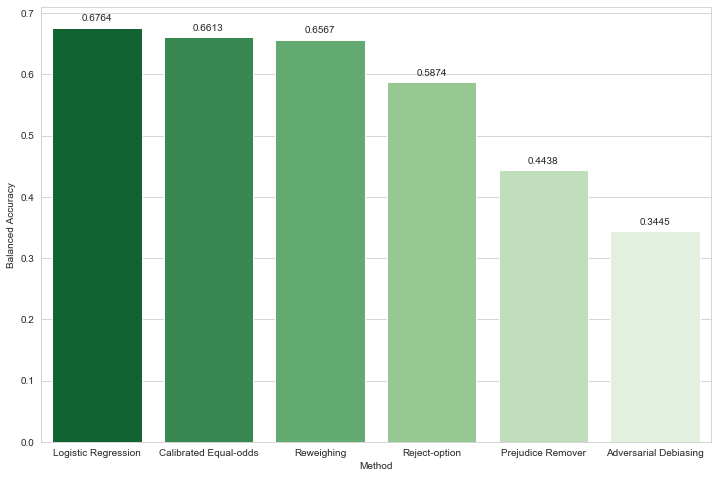

In [153]:
plot_results(x = 'Method', y = 'Result', data = bal_accs, 
    metricname = 'Balanced Accuracy', saveto = 'RES_BAL_ACC.png',
    order = bal_accs.sort_values('Result', ascending = False).Method)

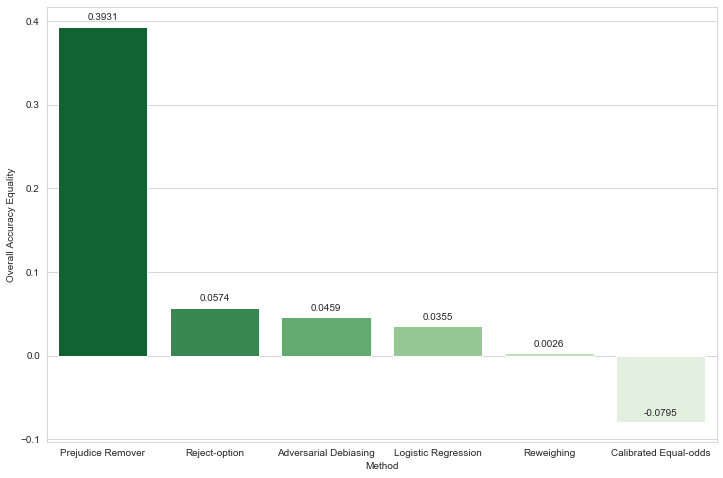

In [156]:
plot_results(x = 'Method', y = 'Result', data = acc_eqs, 
    metricname = 'Overall Accuracy Equality', saveto = 'RES_ACC_EQS.png',
    order = acc_eqs.sort_values('Result', ascending = False).Method)

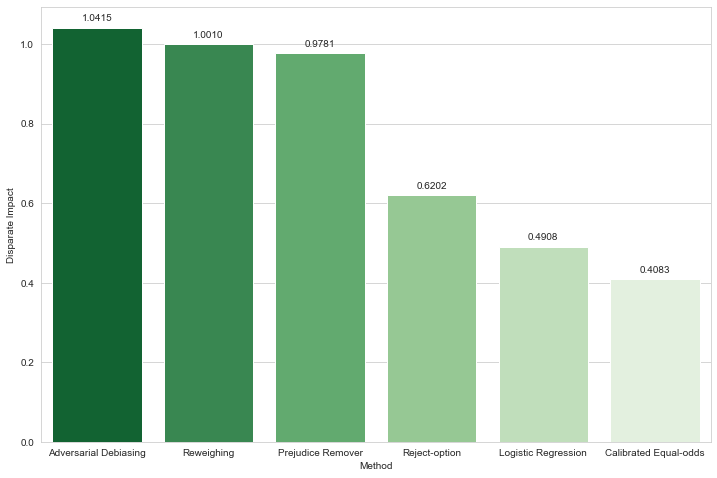

In [157]:
plot_results(x = 'Method', y = 'Result', data = disp_imps, 
    metricname = 'Disparate Impact', saveto = 'RES_DISP_IMPS.png',
    order = disp_imps.sort_values('Result', ascending = False).Method)

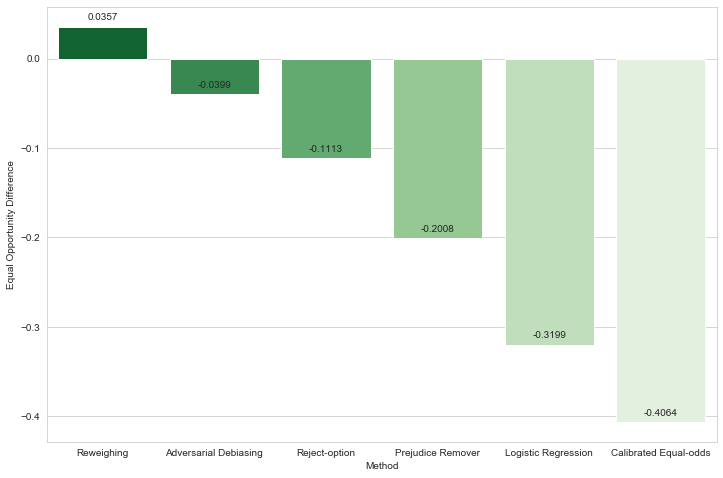

In [158]:
plot_results(x = 'Method', y = 'Result', data = eq_opps, 
    metricname = 'Equal Opportunity Difference', saveto = 'RES_EQ_OPPS.png',
    order = eq_opps.sort_values('Result', ascending = False).Method)

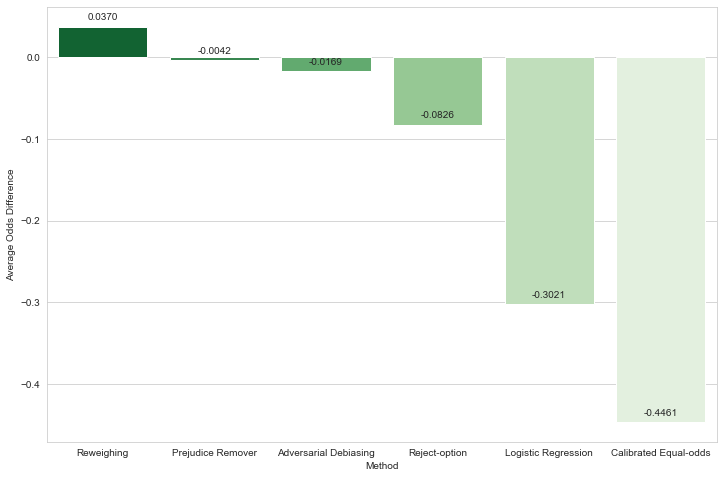

In [159]:
plot_results(x = 'Method', y = 'Result', data = avg_odds, 
    metricname = 'Average Odds Difference', saveto = 'RES_AVG_ODDS.png',
    order = avg_odds.sort_values('Result', ascending = False).Method)

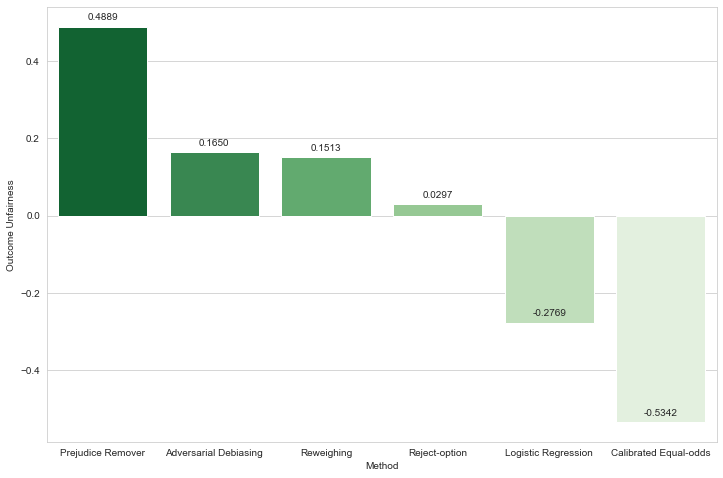

In [160]:
plot_results(x = 'Method', y = 'Result', data = out_unfs, 
    metricname = 'Outcome Unfairness', saveto = 'RES_OUT_UNFS.png',
    order = out_unfs.sort_values('Result', ascending = False).Method)

#### Plot from .json

In [68]:
def plot_results_from_json(filenames, metricname, saveto, set_lims, xlimits, ylimits):
    plt.figure(figsize = (12, 8))
    sns.set_style('whitegrid')
    palette = sns.color_palette('Set2', 6)
    for i, filename in enumerate(filenames):
        with open(os.path.join(FILES, filename)) as file:
            metric_threshs = json.load(file)
            ax = sns.lineplot(x = class_thresh_arr, y = metric_threshs, color = palette[i])
    ax.axvline(best_class_thresh, color = 'k', linestyle = ':')
    ax.set_xlabel('Classification Thresholds', fontsize = 14, fontweight = 'bold')
    ax.set_ylabel(metricname, fontsize = 14, fontweight = 'bold')
    if set_lims == True:
        ax.set_xlim(xlimits)
        ax.set_ylim(ylimits)
    plt.legend(['Logisitic Regression', 'Reweighing', 'Adversarial Debiasing', \
        'Prejudice Remover', 'Reject-option Classification', 'Calibrated Equal-Odds'])
    plt.savefig(saveto, bbox_inches = 'tight')

In [67]:
# plot_results_from_json(filenames = ['LR_bal_acc_arr.json', 'RW_bal_acc_arr.json', 'AD_bal_acc_arr.json', 
#     'PR_bal_acc_arr.json', 'ROC_bal_acc_arr.json', 'CEOD_bal_acc_arr.json'], 
#     xlimits = (0.0, 1.0), ylimits = (0.0, 1.0), set_lims = False, 
#     metricname = 'Balanced Accuracy', saveto = 'RES_balanced_accuracy.png')

In [66]:
# plot_results_from_json(filenames = ['LR_acc_equal_arr.json', 'RW_acc_equal_arr.json', 'AD_acc_equal_arr.json', 
#     'PR_acc_equal_arr.json', 'ROC_acc_equal_arr.json', 'CEOD_acc_equal_arr.json'],
#     xlimits = (0.0, 1.0), ylimits = (0.0, 1.0), set_lims = False,
#     metricname = 'Accuracy Equality', saveto = 'RES_accuracy_equality.png')

In [65]:
# plot_results_from_json(filenames = ['LR_avg_odds_diff_arr.json', 'RW_avg_odds_diff_arr.json', 'AD_avg_odds_diff_arr.json', 
#     'PR_avg_odds_diff_arr.json', 'ROC_avg_odds_diff_arr.json', 'CEOD_avg_odds_diff_arr.json'], 
#     xlimits = (0.0, 1.0), ylimits = (0.0, 1.0), set_lims = False,
#     metricname = 'Average Odds Difference', saveto = 'RES_average_odds.png')

In [64]:
# plot_results_from_json(filenames = ['LR_eq_opp_diff_arr.json', 'RW_eq_opp_diff_arr.json', 'AD_eq_opp_diff_arr.json', 
#     'PR_eq_opp_diff_arr.json', 'ROC_eq_opp_diff_arr.json', 'CEOD_eq_opp_diff_arr.json'], 
#     xlimits = (0.0, 1.0), ylimits = (0.0, 1.0), set_lims = False,
#     metricname = 'Equal Opportunity Difference', saveto = 'RES_equal_opps.png')

In [63]:
# plot_results_from_json(filenames = ['LR_outcome_unfair_arr.json', 'RW_outcome_unfair_arr.json', 'AD_outcome_unfair_arr.json', 
#     'PR_outcome_unfair_arr.json', 'ROC_outcome_unfair_arr.json', 'CEOD_outcome_unfair_arr.json'],
#     xlimits = (0.0, 1.0), ylimits = (0.0, 1.0), set_lims = False,
#     metricname = 'Outcome Unfairness', saveto = 'RES_outcome_unfair.png')

In [62]:
# plot_results_from_json(filenames = ['LR_disp_imp_arr.json', 'RW_disp_imp_arr.json', 'AD_disp_imp_arr.json', 
#     'PR_disp_imp_arr.json', 'ROC_disp_imp_arr.json', 'CEOD_disp_imp_arr.json'], 
#     xlimits = (0.0, 1.0), ylimits = (-0.1, 1.5), set_lims = True,
#     metricname = 'Disparate Impact', saveto = 'RES_disp_imp.png')